### Feature selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('../../data/housing/housing_prices.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaperbedroom,bbratio
0,5250000,5500,3,2,1,1,0,1,0,0,0,0,1,0,1833.333333,0.666667
1,4480000,4040,3,1,2,1,0,0,0,0,1,0,1,0,1346.666667,0.333333
2,3570000,3640,2,1,1,1,0,0,0,0,0,0,0,1,1820.000000,0.500000
3,2870000,3040,2,1,1,0,0,0,0,0,0,0,0,1,1520.000000,0.500000
4,3570000,4500,2,1,1,0,0,0,0,0,0,0,0,0,2250.000000,0.500000


#### predictors

In [4]:
predictors = df.columns[1:]
predictors

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom',
       'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'semi-furnished', 'unfurnished', 'areaperbedroom', 'bbratio'],
      dtype='object')

#### Forward Selector

In [5]:
pipe = make_pipeline(MinMaxScaler(), LinearRegression())
#pipe = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False), MinMaxScaler(), LinearRegression())
forward_selector = SequentialFeatureSelector(pipe, n_features_to_select = 'auto', tol = 0.00001, direction = 'forward', scoring = 'r2')

In [6]:
forward_selector.fit(df[predictors], df['price'])

SequentialFeatureSelector(estimator=Pipeline(steps=[('minmaxscaler',
                                                     MinMaxScaler()),
                                                    ('linearregression',
                                                     LinearRegression())]),
                          n_features_to_select='auto', scoring='r2', tol=1e-05)

In [7]:
forward_selector.get_feature_names_out()

array(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'unfurnished', 'areaperbedroom'],
      dtype=object)

#### Backward Selector

In [8]:
pipe = make_pipeline(MinMaxScaler(), LinearRegression())
#pipe = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False), MinMaxScaler(), LinearRegression())
backward_selector = SequentialFeatureSelector(pipe, n_features_to_select = 'auto', tol = 0.00001, direction = 'backward', scoring = 'r2')

In [9]:
backward_selector.fit(df[predictors], df['price'])

SequentialFeatureSelector(direction='backward',
                          estimator=Pipeline(steps=[('minmaxscaler',
                                                     MinMaxScaler()),
                                                    ('linearregression',
                                                     LinearRegression())]),
                          n_features_to_select='auto', scoring='r2', tol=1e-05)

In [10]:
backward_selector.get_feature_names_out()

array(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'unfurnished', 'areaperbedroom'],
      dtype=object)

#### dataframe with selected features

In [11]:
selected_predictors = backward_selector.get_feature_names_out()

In [12]:
dfs = pd.concat([df['price'], df[selected_predictors]], axis = 1)
dfs.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,unfurnished,areaperbedroom
0,5250000,5500,3,2,1,1,0,1,0,0,0,0,0,1833.333333
1,4480000,4040,3,1,2,1,0,0,0,0,1,0,0,1346.666667
2,3570000,3640,2,1,1,1,0,0,0,0,0,0,1,1820.000000
3,2870000,3040,2,1,1,0,0,0,0,0,0,0,1,1520.000000
4,3570000,4500,2,1,1,0,0,0,0,0,0,0,0,2250.000000


#### train/test split

In [13]:
X_train, X_test = train_test_split(dfs, test_size = 0.20, random_state = 4467)

In [14]:
pipeline = make_pipeline(PolynomialFeatures(degree = 2, include_bias = False), MinMaxScaler(), LinearRegression())
pipeline.fit(X_train[selected_predictors], X_train['price'])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [15]:
X_train['predicted'] = pipeline.predict(X_train[selected_predictors])
X_test['predicted'] = pipeline.predict(X_test[selected_predictors])

In [16]:
# error on train set
print('RMSE_train %.2f$' %np.sqrt(mean_squared_error(X_train['price'], X_train['predicted'])))
print('RSQR_train %.4f' %r2_score(X_train['price'], X_train['predicted']))

RMSE_train 856309.05$
RSQR_train 0.7938


In [17]:
# error on test set
print('RMSE_test %.2f$' %np.sqrt(mean_squared_error(X_test['price'], X_test['predicted'])))
print('RSQR_test %.4f' %r2_score(X_test['price'], X_test['predicted']))

RMSE_test 1115981.20$
RSQR_test 0.6103


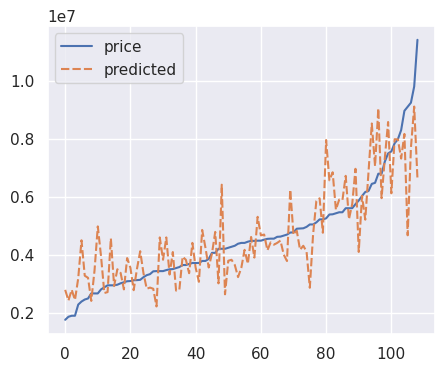

In [18]:
fig, axs = plt.subplots(1, 1, figsize = (5, 4))
sns.lineplot(ax = axs, data = X_test[['price', 'predicted']].sort_values(by = 'price', ignore_index = True));